In [1]:
from brian2 import *
import matplotlib.pyplot as plt
from parameters_brian2 import *
import time

In [2]:
# Parameters
band_type = 'tremor'
[w1, w2, w3, w4, w5, w6, w7, w8, w9, w10, w11] = W[band_type]

In [3]:
## without DBS Signal

# Equations
eqs = Equations(
    """
dE_cx/dt = (- E_cx + (k_e - E_cx) * (1 / (1 + exp(- b_e * ((w1 * E_th) - thet_e)))) - (1 / (1 + exp(b_e * thet_e)))) / tau_cx : 1
dE_th/dt = (- E_th + (k_e - E_th) * (1 / (1 + exp(- b_e * ((w2 * E_cx - w3 * I_nrt + w4 * E_dcn - w5 * I_gpi) - thet_e)))) - (1 / (1 + exp(b_e * thet_e)))) / tau_th : 1
dI_nrt/dt = (- I_nrt + (k_i - I_nrt) * (1 / (1 + exp(- b_i * ((w6 * E_cx) - thet_i)))) - (1 / (1 + exp(b_i * thet_i)))) / tau_nrt : 1
dE_dcn/dt = (- E_dcn + (k_e - E_dcn) * (1 / (1 + exp(- b_e * (ext - thet_e)))) - (1 / (1 + exp(b_e * thet_e)))) / tau_dcn : 1
dI_gpe/dt = (- I_gpe + (k_i - I_gpe) * (1 / (1 + exp(- b_i * ((w7 * E_stn - w8 * I_gpe) - thet_i)))) - (1 / (1 + exp(b_i * thet_i)))) / tau_gpe : 1
dI_gpi/dt = (- I_gpi + (k_i - I_gpi) * (1 / (1 + exp(- b_i * ((w9 * E_stn) - thet_i)))) - (1 / (1 + exp(b_i * thet_i)))) / tau_gpi : 1
dE_stn/dt = (- E_stn + (k_e - E_stn) * (1 / (1 + exp(- b_e * ((w10 * E_cx - w11 * I_gpe) - thet_e)))) - (1 / (1 + exp(b_e * thet_e)))) / tau_stn : 1
"""
)

In [4]:
## Neuron simulation

start_time = time.time()

N = 1
P = NeuronGroup(N, model=eqs, method='euler')

# Initialization
P.E_cx=0
P.E_th=0
P.I_nrt=0
P.E_dcn=0
P.I_gpe=0
P.I_gpi=0
P.E_stn=0


# Record traces from neurons 
variables = ["E_cx", "E_th", "I_nrt", "E_dcn", "I_gpe", "I_gpi", "E_stn"]
trace = StateMonitor(P, variables, record=True)
run(1000 * ms, report="text")
print("--- %s seconds ---" % (time.time() - start_time))

Starting simulation at t=0. s for a duration of 1. s
1. s (100%) simulated in < 1s
--- 5.648821830749512 seconds ---


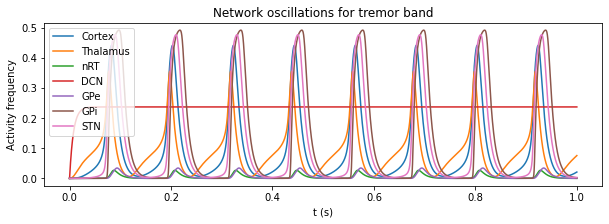

In [5]:
## Display of results

fig,ax=plt.subplots(figsize=(10,3))
for i in range(N):
    traces=[trace.E_cx[i], trace.E_th[i], trace.I_nrt[i], trace.E_dcn[i], trace.I_gpe[i], trace.I_gpi[i], trace.E_stn[i]]
    for i,name in enumerate(variables):
        ax.plot(trace.t, traces[i])
    
xlabel("t (s)")
ylabel("Activity frequency")
legend(['Cortex','Thalamus','nRT','DCN','GPe','GPi','STN'])
title(f"Network oscillations for {band_type} band")
show()

In [6]:
### DBS Signal

def sigma_sum_odd(start, end, t, expression):
    return sum(expression(n,t) for n in range(start, end+2, 2))


def DBS(n, t):
    return A*(4/np.pi)*((1/n)*np.sin(2*np.pi*n*f*t))

t_array = np.arange(0, 1, 1.e-4)
dbs = sigma_sum_odd(1, 1001, t_array, DBS)
stimulus = TimedArray(dbs, dt=0.1 * ms)


# Equations
eqs_dbs = Equations(
    """
dE_cx/dt = (- E_cx + (k_e - E_cx) * (1 / (1 + exp(- b_e * ((w1 * E_th) - thet_e)))) - (1 / (1 + exp(b_e * thet_e)))) / tau_cx : 1
dE_th/dt = (- E_th + (k_e - E_th) * (1 / (1 + exp(- b_e * ((w2 * E_cx - w3 * I_nrt + w4 * E_dcn - w5 * I_gpi) - thet_e)))) - (1 / (1 + exp(b_e * thet_e)))) / tau_th : 1
dI_nrt/dt = (- I_nrt + (k_i - I_nrt) * (1 / (1 + exp(- b_i * ((w6 * E_cx) - thet_i)))) - (1 / (1 + exp(b_i * thet_i)))) / tau_nrt : 1
dE_dcn/dt = (- E_dcn + (k_e - E_dcn) * (1 / (1 + exp(- b_e * (ext - thet_e)))) - (1 / (1 + exp(b_e * thet_e)))) / tau_dcn : 1
dI_gpe/dt = (- I_gpe + (k_i - I_gpe) * (1 / (1 + exp(- b_i * ((w7 * E_stn - w8 * I_gpe) - thet_i)))) - (1 / (1 + exp(b_i * thet_i)))) / tau_gpe : 1
dI_gpi/dt = (- I_gpi + (k_i - I_gpi) * (1 / (1 + exp(- b_i * ((w9 * E_stn) - thet_i)))) - (1 / (1 + exp(b_i * thet_i)))) / tau_gpi : 1
dE_stn/dt = (- E_stn + (k_e - E_stn) * (1 / (1 + exp(- b_e * ((w10 * E_cx - w11 * I_gpe + dbs) - thet_e)))) - (1 / (1 + exp(b_e * thet_e)))) / tau_stn : 1
dbs = stimulus(t): 1
"""
)

WARNING    /Users/clemencevast/opt/anaconda3/envs/ComputationalRobotics/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  after removing the cwd from sys.path.
 [py.warnings]


In [10]:
## Neuron simulation with DBS

start_time = time.time()

N = 1
P = NeuronGroup(N, model=eqs_dbs, method='euler')

# Initialization
P.E_cx=0
P.E_th=0
P.I_nrt=0
P.E_dcn=0
P.I_gpe=0
P.I_gpi=0
P.E_stn=0


# Record traces from neurons 
variables = ["E_cx", "E_th", "I_nrt", "E_dcn", "I_gpe", "I_gpi", "E_stn"]
trace = StateMonitor(P, variables, record=True)
run(1000 * ms, report="text")
print("--- %s seconds ---" % (time.time() - start_time))

Starting simulation at t=0. s for a duration of 1. s
1. s (100%) simulated in < 1s
--- 0.5746607780456543 seconds ---


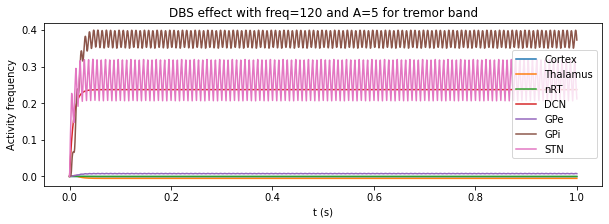

In [11]:
## Display of results

fig,ax=plt.subplots(figsize=(10,3))
for i in range(N):
    traces=[trace.E_cx[i], trace.E_th[i], trace.I_nrt[i], trace.E_dcn[i], trace.I_gpe[i], trace.I_gpi[i], trace.E_stn[i]]
    for i,name in enumerate(variables):
        ax.plot(trace.t, traces[i])
    
xlabel("t (s)")
ylabel("Activity frequency")
legend(['Cortex','Thalamus','nRT','DCN','GPe','GPi','STN'])
title(f"DBS effect with freq={f} and A={A} for {band_type} band")
show()